实现LLAMA3

In [1]:
from pathlib import Path
import tiktoken
from tiktoken.load import load_tiktoken_bpe
import torch
import json
import matplotlib.pyplot as plt

tokenizer_path = "Meta-Llama-3-8B/tokenizer.model"
special_tokens = [
            "<|begin_of_text|>",
            "<|end_of_text|>",
            "<|reserved_special_token_0|>",
            "<|reserved_special_token_1|>",
            "<|reserved_special_token_2|>",
            "<|reserved_special_token_3|>",
            "<|start_header_id|>",
            "<|end_header_id|>",
            "<|reserved_special_token_4|>",
            "<|eot_id|>",  # end of turn
        ] + [f"<|reserved_special_token_{i}|>" for i in range(5, 256 - 5)]
mergeable_ranks = load_tiktoken_bpe(tokenizer_path)
tokenizer = tiktoken.Encoding(
    name=Path(tokenizer_path).name,
    pat_str=r"(?i:'s|'t|'re|'ve|'m|'ll|'d)|[^\r\n\p{L}\p{N}]?\p{L}+|\p{N}{1,3}| ?[^\s\p{L}\p{N}]+[\r\n]*|\s*[\r\n]+|\s+(?!\S)|\s+",
    mergeable_ranks=mergeable_ranks,
    special_tokens={token: len(mergeable_ranks) + i for i, token in enumerate(special_tokens)},
)

tokenizer.decode(tokenizer.encode("hello world!"))

'hello world!'

加载模型

In [2]:
model = torch.load("Meta-Llama-3-8B/consolidated.00.pth")
print(json.dumps(list(model.keys())[:20], indent=4))

[
    "tok_embeddings.weight",
    "layers.0.attention.wq.weight",
    "layers.0.attention.wk.weight",
    "layers.0.attention.wv.weight",
    "layers.0.attention.wo.weight",
    "layers.0.feed_forward.w1.weight",
    "layers.0.feed_forward.w3.weight",
    "layers.0.feed_forward.w2.weight",
    "layers.0.attention_norm.weight",
    "layers.0.ffn_norm.weight",
    "layers.1.attention.wq.weight",
    "layers.1.attention.wk.weight",
    "layers.1.attention.wv.weight",
    "layers.1.attention.wo.weight",
    "layers.1.feed_forward.w1.weight",
    "layers.1.feed_forward.w3.weight",
    "layers.1.feed_forward.w2.weight",
    "layers.1.attention_norm.weight",
    "layers.1.ffn_norm.weight",
    "layers.2.attention.wq.weight"
]


In [3]:
with open("Meta-Llama-3-8B/params.json", "r") as f:
    config = json.load(f)
config

{'dim': 4096,
 'n_layers': 32,
 'n_heads': 32,
 'n_kv_heads': 8,
 'vocab_size': 128256,
 'multiple_of': 1024,
 'ffn_dim_multiplier': 1.3,
 'norm_eps': 1e-05,
 'rope_theta': 500000.0}

In [4]:
dim = config["dim"]
n_layers = config["n_layers"]
n_heads = config["n_heads"]
n_kv_heads = config["n_kv_heads"]
vocab_size = config["vocab_size"]
multiple_of = config["multiple_of"]
ffn_dim_multiplier = config["ffn_dim_multiplier"]
norm_eps = config["norm_eps"]
rope_theta = torch.tensor(config["rope_theta"])

In [5]:
prompt = "Every day, I wake up and think about how I can make the world a better place. I believe that small actions can lead to big changes. For example, I always try to be kind to others, even when I'm having a bad day. I also try to reduce my carbon footprint by using public transport and recycling whenever possible. What are some ways you think we can all contribute to making the world a better place?"
prompt_tokens = [128000] + tokenizer.encode(prompt)
#128000 is the <|begin_of_text|> token
print(prompt_tokens)
prompt_tokens = torch.tensor(prompt_tokens)
prompt_split_as_tokens = [tokenizer.decode([token.item()]) for token in prompt_tokens]
print(prompt_split_as_tokens)
prompt_tokens.shape

[128000, 11769, 1938, 11, 358, 15508, 709, 323, 1781, 922, 1268, 358, 649, 1304, 279, 1917, 264, 2731, 2035, 13, 358, 4510, 430, 2678, 6299, 649, 3063, 311, 2466, 4442, 13, 1789, 3187, 11, 358, 2744, 1456, 311, 387, 3169, 311, 3885, 11, 1524, 994, 358, 2846, 3515, 264, 3958, 1938, 13, 358, 1101, 1456, 311, 8108, 856, 12782, 43972, 555, 1701, 586, 7710, 323, 34978, 15716, 3284, 13, 3639, 527, 1063, 5627, 499, 1781, 584, 649, 682, 17210, 311, 3339, 279, 1917, 264, 2731, 2035, 30]
['<|begin_of_text|>', 'Every', ' day', ',', ' I', ' wake', ' up', ' and', ' think', ' about', ' how', ' I', ' can', ' make', ' the', ' world', ' a', ' better', ' place', '.', ' I', ' believe', ' that', ' small', ' actions', ' can', ' lead', ' to', ' big', ' changes', '.', ' For', ' example', ',', ' I', ' always', ' try', ' to', ' be', ' kind', ' to', ' others', ',', ' even', ' when', ' I', "'m", ' having', ' a', ' bad', ' day', '.', ' I', ' also', ' try', ' to', ' reduce', ' my', ' carbon', ' footprint', ' by', 

torch.Size([87])

从Token转为Embedding

In [6]:
embedding_layer = torch.nn.Embedding(vocab_size, dim, padding_idx=0)
embedding_layer.weight.data = model["tok_embeddings.weight"]
token_embeddings_unnormalized = embedding_layer(prompt_tokens).to(torch.bfloat16)
token_embeddings_unnormalized.shape

torch.Size([87, 4096])

In [7]:
def rms(tensor,weight=1.0):
    return weight * (tensor * torch.rsqrt(tensor.pow(2).mean(-1, keepdim=True) + norm_eps))

In [8]:
token_embedding = rms(token_embeddings_unnormalized, weight=model["layers.0.attention_norm.weight"])

token_embedding.shape

torch.Size([87, 4096])

In [9]:
model.keys()

dict_keys(['tok_embeddings.weight', 'layers.0.attention.wq.weight', 'layers.0.attention.wk.weight', 'layers.0.attention.wv.weight', 'layers.0.attention.wo.weight', 'layers.0.feed_forward.w1.weight', 'layers.0.feed_forward.w3.weight', 'layers.0.feed_forward.w2.weight', 'layers.0.attention_norm.weight', 'layers.0.ffn_norm.weight', 'layers.1.attention.wq.weight', 'layers.1.attention.wk.weight', 'layers.1.attention.wv.weight', 'layers.1.attention.wo.weight', 'layers.1.feed_forward.w1.weight', 'layers.1.feed_forward.w3.weight', 'layers.1.feed_forward.w2.weight', 'layers.1.attention_norm.weight', 'layers.1.ffn_norm.weight', 'layers.2.attention.wq.weight', 'layers.2.attention.wk.weight', 'layers.2.attention.wv.weight', 'layers.2.attention.wo.weight', 'layers.2.feed_forward.w1.weight', 'layers.2.feed_forward.w3.weight', 'layers.2.feed_forward.w2.weight', 'layers.2.attention_norm.weight', 'layers.2.ffn_norm.weight', 'layers.3.attention.wq.weight', 'layers.3.attention.wk.weight', 'layers.3.atten

In [10]:
qlayer = model["layers.0.attention.wq.weight"]
head_dim = qlayer.shape[0] // n_heads
qlayer = qlayer.view(n_heads, head_dim, dim)
q0 = qlayer[0]
q0.shape


torch.Size([128, 4096])

In [11]:
q_per_token = torch.matmul(token_embedding, q0.T)
q_per_token.shape

torch.Size([87, 128])

ROPE

In [12]:
q_per_token_rope = q_per_token.float().view(q_per_token.shape[0],-1,2)
q_per_token_rope.shape


torch.Size([87, 64, 2])

In [13]:
zerotooneSplit = torch.tensor(range(64))/64
zerotooneSplit

tensor([0.0000, 0.0156, 0.0312, 0.0469, 0.0625, 0.0781, 0.0938, 0.1094, 0.1250,
        0.1406, 0.1562, 0.1719, 0.1875, 0.2031, 0.2188, 0.2344, 0.2500, 0.2656,
        0.2812, 0.2969, 0.3125, 0.3281, 0.3438, 0.3594, 0.3750, 0.3906, 0.4062,
        0.4219, 0.4375, 0.4531, 0.4688, 0.4844, 0.5000, 0.5156, 0.5312, 0.5469,
        0.5625, 0.5781, 0.5938, 0.6094, 0.6250, 0.6406, 0.6562, 0.6719, 0.6875,
        0.7031, 0.7188, 0.7344, 0.7500, 0.7656, 0.7812, 0.7969, 0.8125, 0.8281,
        0.8438, 0.8594, 0.8750, 0.8906, 0.9062, 0.9219, 0.9375, 0.9531, 0.9688,
        0.9844])

In [14]:
freqs = 1.0 / (rope_theta ** zerotooneSplit)
freqs

tensor([1.0000e+00, 8.1462e-01, 6.6360e-01, 5.4058e-01, 4.4037e-01, 3.5873e-01,
        2.9223e-01, 2.3805e-01, 1.9392e-01, 1.5797e-01, 1.2869e-01, 1.0483e-01,
        8.5397e-02, 6.9566e-02, 5.6670e-02, 4.6164e-02, 3.7606e-02, 3.0635e-02,
        2.4955e-02, 2.0329e-02, 1.6560e-02, 1.3490e-02, 1.0990e-02, 8.9523e-03,
        7.2927e-03, 5.9407e-03, 4.8394e-03, 3.9423e-03, 3.2114e-03, 2.6161e-03,
        2.1311e-03, 1.7360e-03, 1.4142e-03, 1.1520e-03, 9.3847e-04, 7.6450e-04,
        6.2277e-04, 5.0732e-04, 4.1327e-04, 3.3666e-04, 2.7425e-04, 2.2341e-04,
        1.8199e-04, 1.4825e-04, 1.2077e-04, 9.8381e-05, 8.0143e-05, 6.5286e-05,
        5.3183e-05, 4.3324e-05, 3.5292e-05, 2.8750e-05, 2.3420e-05, 1.9078e-05,
        1.5542e-05, 1.2660e-05, 1.0313e-05, 8.4015e-06, 6.8440e-06, 5.5752e-06,
        4.5417e-06, 3.6997e-06, 3.0139e-06, 2.4551e-06])

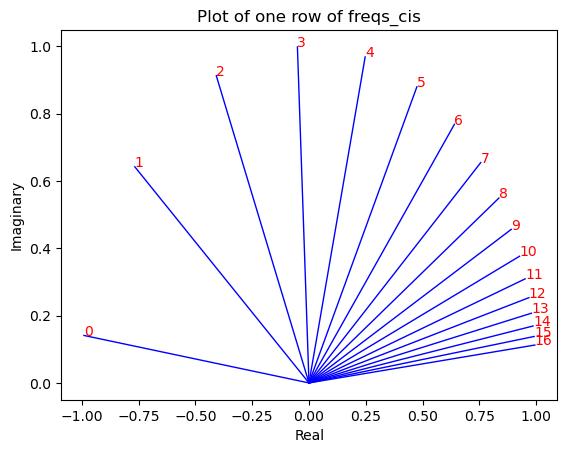

In [15]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
freqs_for_each_token = torch.outer(torch.arange(17), freqs)
freqs_for_each_token

freqs_cis = torch.polar(torch.ones_like(freqs_for_each_token), freqs_for_each_token)
freqs_cis.shape

# viewing tjhe third row of freqs_cis
value = freqs_cis[3]
plt.figure()
for i, element in enumerate(value[:17]):
    plt.plot([0, element.real], [0, element.imag], color='blue', linewidth=1, label=f"Index: {i}")
    plt.annotate(f"{i}", xy=(element.real, element.imag), color='red')
plt.xlabel('Real')
plt.ylabel('Imaginary')
plt.title('Plot of one row of freqs_cis')
plt.show()

In [20]:
freqs_for_each_token.shape

torch.Size([17, 64])

In [19]:
value


tensor([-0.9900+1.4112e-01j, -0.7663+6.4249e-01j, -0.4078+9.1309e-01j,
        -0.0509+9.9870e-01j,  0.2471+9.6899e-01j,  0.4747+8.8016e-01j,
         0.6397+7.6862e-01j,  0.7556+6.5498e-01j,  0.8355+5.4950e-01j,
         0.8898+4.5638e-01j,  0.9264+3.7654e-01j,  0.9510+3.0933e-01j,
         0.9674+2.5340e-01j,  0.9783+2.0719e-01j,  0.9856+1.6919e-01j,
         0.9904+1.3805e-01j,  0.9936+1.1258e-01j,  0.9958+9.1774e-02j,
         0.9972+7.4796e-02j,  0.9981+6.0950e-02j,  0.9988+4.9661e-02j,
         0.9992+4.0460e-02j,  0.9995+3.2963e-02j,  0.9996+2.6854e-02j,
         0.9998+2.1876e-02j,  0.9998+1.7821e-02j,  0.9999+1.4518e-02j,
         0.9999+1.1827e-02j,  1.0000+9.6342e-03j,  1.0000+7.8482e-03j,
         1.0000+6.3933e-03j,  1.0000+5.2081e-03j,  1.0000+4.2426e-03j,
         1.0000+3.4561e-03j,  1.0000+2.8154e-03j,  1.0000+2.2935e-03j,
         1.0000+1.8683e-03j,  1.0000+1.5220e-03j,  1.0000+1.2398e-03j,
         1.0000+1.0100e-03j,  1.0000+8.2274e-04j,  1.0000+6.7022e-04j,
      